## Early prediction of sepsis from clinical data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import csv
from sklearn.metrics import accuracy_score
import seaborn as sns
import pylab
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.impute import KNNImputer
#from fancyimpute import KNN
#import statsmodels.api as sm
#from patsy import dmatrices
from statsmodels.imputation.mice import MICEData as md
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#from fancyimpute import MICE as MICE
# from sklearn.impute import IterativeImputer

## Problem Statement:

**The early prediction of sepsis is potentially life-saving, and we challenge participants to predict sepsis 6 hours before the clinical prediction of sepsis. Conversely, the late prediction of sepsis is potentially life-threatening, and predicting sepsis in non-sepsis patients (or predicting sepsis very early in sepsis patients) consumes limited hospital resources. For the challenge, we designed a utility function that rewards early predictions and penalizes late predictions as well as false alarms.**

**Load of complete folder**

In [2]:
from os import listdir
a_traincsv = listdir('training')

**Adding additional patient_id & time in dataset and combine overall patient.psv file in one .csv file.**  

In [3]:
with open('train_patient.csv', 'w') as csvoutput:
  writer = csv.writer(csvoutput, lineterminator='\n')

  for ind, csv_name in enumerate(a_traincsv):
    with open('training/'+ csv_name,'r') as csvinput:
      reader = csv.reader(csvinput, delimiter='|')
      all = []
      if ind ==0 :
        row = next(reader)
        row.append('Patient_id')
        row.append('time')
        all.append(row)
      else:
        row = next(reader)

      for i,row in enumerate(reader):
        row.append(ind)
        row.append(i)
        all.append(row)
      writer.writerows(all)

In [4]:
df_copy = pd.read_csv('train_patient.csv')

In [5]:
df = df_copy.copy()

In [6]:
df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,1,0,0,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,2,0,0,1
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,3,0,0,2
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,4,0,0,3
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,83.14,0,NaN,NaN,-0.03,5,0,0,4


In [7]:
df.isnull().sum()

HR                   61189
O2Sat                95079
Temp                523314
SBP                 120201
MAP                  80858
DBP                 380297
Resp                 77258
EtCO2               790215
BaseExcess          707834
HCO3                726598
FiO2                678060
pH                  699600
PaCO2               720927
SaO2                751055
AST                 778395
BUN                 725739
Alkalinephos        778683
Calcium             750897
Chloride            724438
Creatinine          737728
Bilirubin_direct    789033
Glucose             693559
Lactate             763072
Magnesium           728734
Phosphate           750319
Potassium           704379
Bilirubin_total     780522
TroponinI           789250
Hct                 697157
Hgb                 720394
PTT                 751909
WBC                 730867
Fibrinogen          784185
Platelets           738716
Age                      0
Gender                   0
Unit1               386165
U

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790215 entries, 0 to 790214
Data columns (total 43 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HR                729026 non-null  float64
 1   O2Sat             695136 non-null  float64
 2   Temp              266901 non-null  float64
 3   SBP               670014 non-null  float64
 4   MAP               709357 non-null  float64
 5   DBP               409918 non-null  float64
 6   Resp              712957 non-null  float64
 7   EtCO2             0 non-null       float64
 8   BaseExcess        82381 non-null   float64
 9   HCO3              63617 non-null   float64
 10  FiO2              112155 non-null  float64
 11  pH                90615 non-null   float64
 12  PaCO2             69288 non-null   float64
 13  SaO2              39160 non-null   float64
 14  AST               11820 non-null   float64
 15  BUN               64476 non-null   float64
 16  Alkalinephos      11

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HR,729026.0,84.985264,16.940431,20.00,73.00,84.00,96.00,280.00
O2Sat,695136.0,97.265688,2.908794,20.00,96.00,98.00,99.50,100.00
Temp,266901.0,37.026737,0.780317,20.90,36.56,37.06,37.55,42.22
SBP,670014.0,120.962359,21.520567,22.00,105.00,118.50,134.00,281.00
MAP,709357.0,78.767345,15.044038,20.00,68.00,77.00,87.33,300.00
DBP,409918.0,59.985809,12.572771,20.00,51.00,58.50,67.00,298.00
Resp,712957.0,18.773460,5.395750,1.00,15.00,18.00,22.00,69.00
EtCO2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BaseExcess,82381.0,-0.647537,4.286641,-32.00,-3.00,0.00,1.00,100.00
HCO3,63617.0,24.094476,4.396192,0.00,22.00,24.00,27.00,55.00


In [10]:
df.corr()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
HR,1.000000,-0.083892,0.257408,-0.027233,0.113059,0.194198,0.245858,NaN,-0.092058,-0.092635,...,0.026818,-0.185891,-0.032591,0.055879,-0.055879,-0.047555,0.032503,0.047464,-0.003502,0.031963
O2Sat,-0.083892,1.000000,-0.030651,0.041769,0.049761,0.035513,-0.163217,NaN,0.032360,-0.060713,...,-0.022018,-0.043237,-0.029580,-0.053364,0.053364,0.001213,-0.046736,-0.007670,-0.002360,-0.048595
Temp,0.257408,-0.030651,1.000000,0.008748,-0.017643,-0.033184,0.143032,NaN,0.146893,0.078264,...,0.025325,-0.106214,0.058439,-0.161930,0.161930,0.042897,0.097013,0.041924,-0.007288,0.093370
SBP,-0.027233,0.041769,0.008748,1.000000,0.773763,0.534488,0.055809,NaN,0.151605,0.057455,...,0.020214,-0.000401,-0.010027,0.192406,-0.192406,0.035449,0.094355,-0.005123,0.011258,0.097070
MAP,0.113059,0.049761,-0.017643,0.773763,1.000000,0.802643,0.048167,NaN,0.111652,0.021869,...,0.015516,-0.171660,0.023771,0.217379,-0.217379,0.037319,0.050819,-0.005282,0.010070,0.054056
DBP,0.194198,0.035513,-0.033184,0.534488,0.802643,1.000000,0.054128,NaN,0.080441,0.023210,...,0.033752,-0.330808,0.014550,0.267288,-0.267288,0.028828,0.045990,0.007527,0.006627,0.051459
Resp,0.245858,-0.163217,0.143032,0.055809,0.048167,0.054128,1.000000,NaN,-0.034433,-0.041827,...,0.070787,0.033527,0.006272,0.086136,-0.086136,-0.039412,0.118358,0.055194,-0.002993,0.120100
EtCO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BaseExcess,-0.092058,0.032360,0.146893,0.151605,0.111652,0.080441,-0.034433,NaN,1.000000,0.854823,...,0.072628,-0.046142,0.025591,0.057617,-0.057617,-0.021525,0.155526,0.019161,0.007277,0.157087
HCO3,-0.092635,-0.060713,0.078264,0.057455,0.021869,0.023210,-0.041827,NaN,0.854823,1.000000,...,0.091295,0.019853,0.042743,-0.060735,0.060735,-0.020611,0.118568,-0.014065,-0.007441,0.119727


## Details about particular Attributes.

![](sis_1.png)

![](sis_2.png)

## method to remove nan values using iterative_imputer

In [11]:
def imputation(X,Y):
    X_arr = pd.DataFrame(X).to_numpy(dtype=float)
    Y_arr = pd.DataFrame(Y).to_numpy(dtype=float)
    
    
    add = np.concatenate((X_arr,Y_arr),axis=1)
    imp = IterativeImputer(max_iter=10, random_state=0,sample_posterior=True)
    imp.fit(add)
    impute = np.round(imp.transform(add),decimals=3)
    
    return impute

# Vital Signs:

## HR 	Heart rate (beats per minute)

In [12]:
df['HR'].median()

84.0

In [13]:
df['HR'].mean()

84.98526444873023

In [14]:
df['HR']=df['HR'].fillna(df['HR'].median())

In [15]:
df['HR'].describe()

count    790215.000000
mean         84.908972
std          16.273470
min          20.000000
25%          74.000000
50%          84.000000
75%          94.000000
max         280.000000
Name: HR, dtype: float64

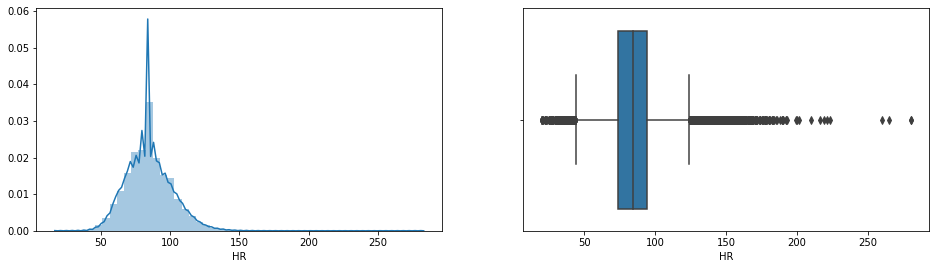

In [16]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['HR'])

plt.subplot(2,2,2)
sns.boxplot(df['HR'])

plt.show()

## O2Sat 	Pulse oximetry (%)

In [17]:
df['O2Sat'].median()

98.0

In [18]:
df['O2Sat']=df['O2Sat'].fillna(df['O2Sat'].median())

In [19]:
df['O2Sat'].describe()

count    790215.000000
mean         97.354040
std           2.738633
min          20.000000
25%          96.000000
50%          98.000000
75%          99.000000
max         100.000000
Name: O2Sat, dtype: float64

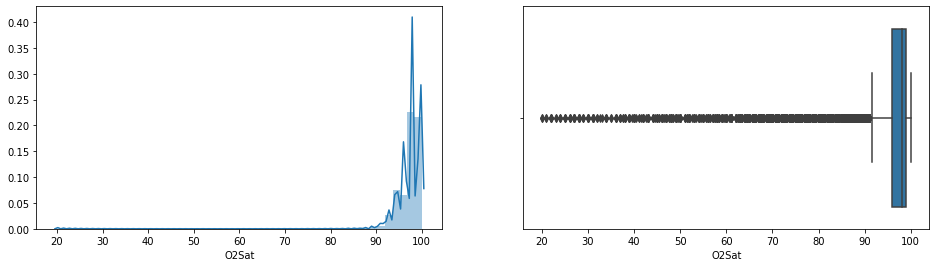

In [20]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['O2Sat'])

plt.subplot(2,2,2)
sns.boxplot(df['O2Sat'])

plt.show()

# Temperature

In [21]:
df['Temp'].describe()

count    266901.000000
mean         37.026737
std           0.780317
min          20.900000
25%          36.560000
50%          37.060000
75%          37.550000
max          42.220000
Name: Temp, dtype: float64

In [22]:
X = df['Temp']
Y = df['SepsisLabel']
impute20=imputation(X,Y)            # Calling of imputation function.

In [23]:
impute20

array([[38.512,  0.   ],
       [36.964,  0.   ],
       [36.043,  0.   ],
       ...,
       [37.271,  1.   ],
       [38.147,  1.   ],
       [37.116,  1.   ]])

In [24]:
# To change the array values with same dataframe define above.

impute_df20=pd.DataFrame(impute20,columns=['base_imp','SepsisLabel'])

df['Temp'] = impute_df20['base_imp']

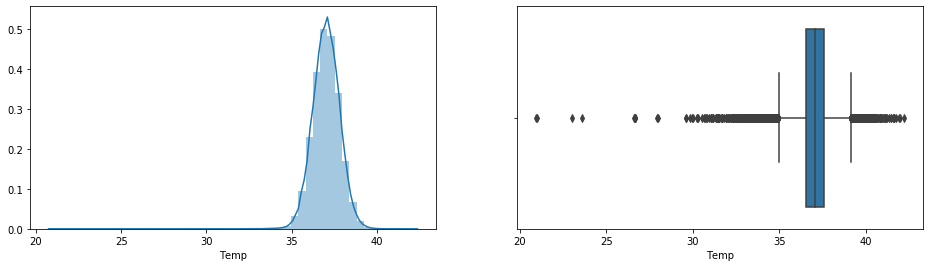

In [25]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Temp'])

plt.subplot(2,2,2)
sns.boxplot(df['Temp'])

plt.show()

## SBP 	Systolic BP (mm Hg)

In [26]:
df['SBP'].median()

118.5

In [27]:
df['SBP']=df['SBP'].fillna(df['SBP'].median())

In [28]:
df['SBP'].describe()

count    790215.000000
mean        120.587806
std          19.836040
min          22.000000
25%         108.000000
50%         118.500000
75%         131.000000
max         281.000000
Name: SBP, dtype: float64

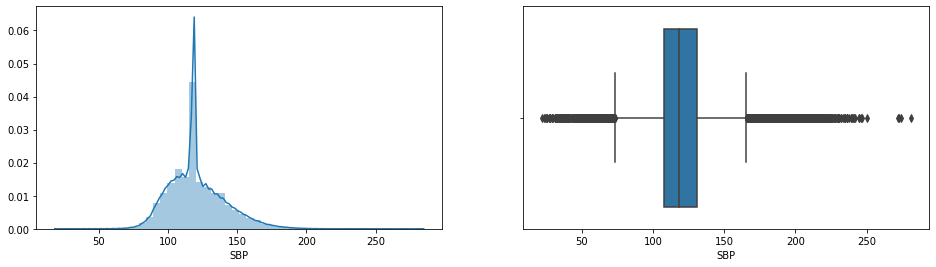

In [29]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['SBP'])

plt.subplot(2,2,2)
sns.boxplot(df['SBP'])

plt.show()

## MAP 	Mean arterial pressure (mm Hg)

In [30]:
df['MAP'].median()

77.0

In [31]:
df['MAP']=df['MAP'].fillna(df['MAP'].median())

In [32]:
df['MAP'].describe()

count    790215.000000
mean         78.586503
std          14.263648
min          20.000000
25%          69.000000
50%          77.000000
75%          86.000000
max         300.000000
Name: MAP, dtype: float64

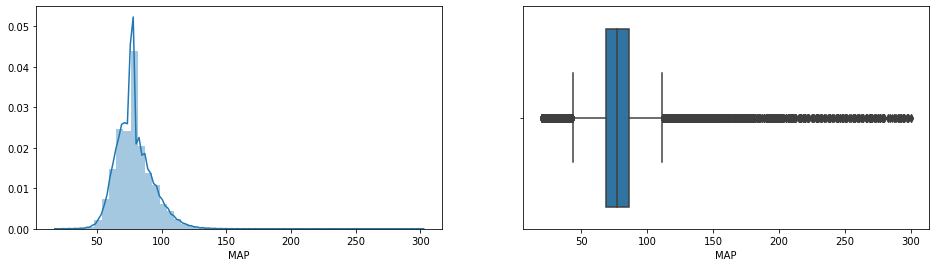

In [33]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['MAP'])

plt.subplot(2,2,2)
sns.boxplot(df['MAP'])

plt.show()

## DBP 	Diastolic BP (mm Hg)

In [34]:
df['DBP'].mean()

59.98580935699335

In [35]:
df['DBP'].median()

58.5

In [36]:
df['DBP']=df['DBP'].fillna(df['DBP'].median())

In [37]:
df['DBP'].describe()

count    790215.000000
mean         59.270752
std           9.085759
min          20.000000
25%          58.000000
50%          58.500000
75%          59.000000
max         298.000000
Name: DBP, dtype: float64

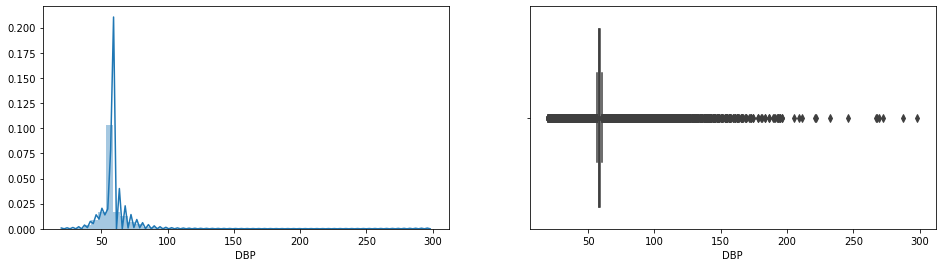

In [38]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['DBP'])

plt.subplot(2,2,2)
sns.boxplot(df['DBP'])

plt.show()

## Resp 	Respiration rate (breaths per minute)

In [39]:
df['Resp'].median()

18.0

In [40]:
df['Resp']=df['Resp'].fillna(df['Resp'].median())

In [41]:
df.Resp.describe()

count    790215.000000
mean         18.697840
std           5.130345
min           1.000000
25%          15.000000
50%          18.000000
75%          21.000000
max          69.000000
Name: Resp, dtype: float64

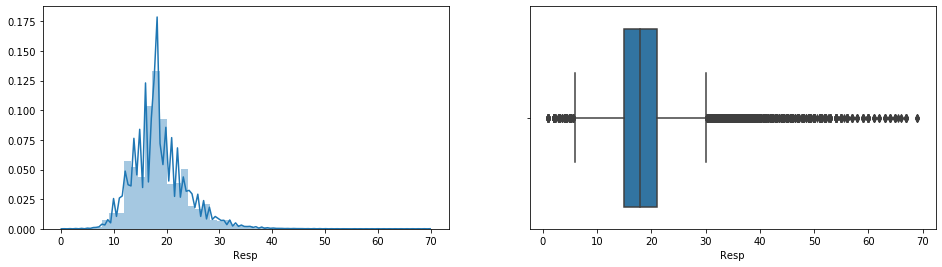

In [42]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Resp'])

plt.subplot(2,2,2)
sns.boxplot(df['Resp'])

plt.show()

## EtCO2 	End tidal carbon dioxide (mm Hg)

In [43]:
df.EtCO2.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: EtCO2, dtype: float64

In [44]:
df.EtCO2.mean()

nan

In [45]:
df =df.drop(['EtCO2'],axis=1)

**From here column name EtCO2 doesnot exist and similar done in other columns**

In [46]:
#base_arr=pd.DataFrame(df['BaseExcess']).to_numpy()
#sepsis_arr=pd.DataFrame(df['SepsisLabel']).to_numpy()
#add=np.concatenate((base_arr,sepsis_arr), axis=1)

In [47]:
#imp = IterativeImputer(max_iter=10, random_state=0,sample_posterior=True)
#imp.fit(add)
#impute=np.round(imp.transform(add))

# Laboratory values

## BaseExcess 	Measure of excess bicarbonate (mmol/L)

In [48]:
df['BaseExcess'].describe()

count    82381.000000
mean        -0.647537
std          4.286641
min        -32.000000
25%         -3.000000
50%          0.000000
75%          1.000000
max        100.000000
Name: BaseExcess, dtype: float64

In [49]:
df['BaseExcess'].isnull().sum()

707834

In [50]:
X = df['BaseExcess']
Y = df['SepsisLabel']
impute=imputation(X,Y)            # Calling of imputation function.

In [51]:
impute

array([[ 3.367,  0.   ],
       [ 5.614,  0.   ],
       [ 3.578,  0.   ],
       ...,
       [-2.75 ,  1.   ],
       [-0.605,  1.   ],
       [ 0.607,  1.   ]])

In [52]:
# To change the array values with same dataframe define above.

impute_df=pd.DataFrame(impute,columns=['base_imp','SepsisLabel'])
df['BaseExcess'] = impute_df['base_imp']

In [53]:
df['BaseExcess'].head()

0     3.367
1     5.614
2     3.578
3    24.000
4     2.259
Name: BaseExcess, dtype: float64

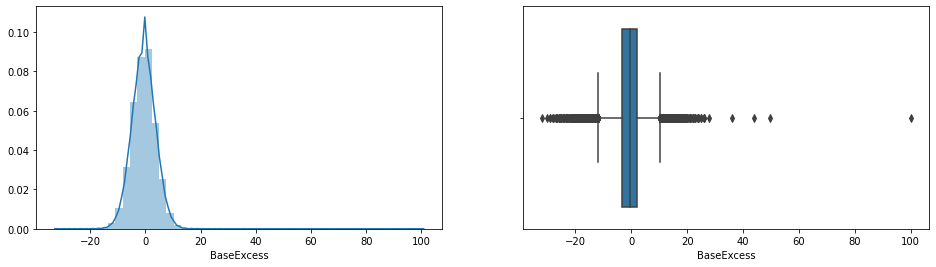

In [54]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['BaseExcess'])

plt.subplot(2,2,2)
sns.boxplot(df['BaseExcess'])

plt.show()

# HCO3 	Bicarbonate (mmol/L)

In [55]:
df['HCO3'].describe()

count    63617.000000
mean        24.094476
std          4.396192
min          0.000000
25%         22.000000
50%         24.000000
75%         27.000000
max         55.000000
Name: HCO3, dtype: float64

In [56]:
df['HCO3'].isnull().sum()

726598

In [57]:
X = df['HCO3']
Y = df['SepsisLabel']
impute1=imputation(X,Y)            # Calling of imputation function.

In [58]:
impute1

array([[22.893,  0.   ],
       [19.332,  0.   ],
       [26.322,  0.   ],
       ...,
       [16.162,  1.   ],
       [23.711,  1.   ],
       [25.115,  1.   ]])

In [59]:
# To change the array values with same dataframe define above.

impute_df1=pd.DataFrame(impute1,columns=['base_imp','SepsisLabel'])
df['HCO3'] = impute_df1['base_imp']

In [60]:
df['HCO3'].describe()

count    790215.000000
mean         24.090623
std           4.393881
min           0.000000
25%          21.140000
50%          24.054000
75%          27.000000
max          55.000000
Name: HCO3, dtype: float64

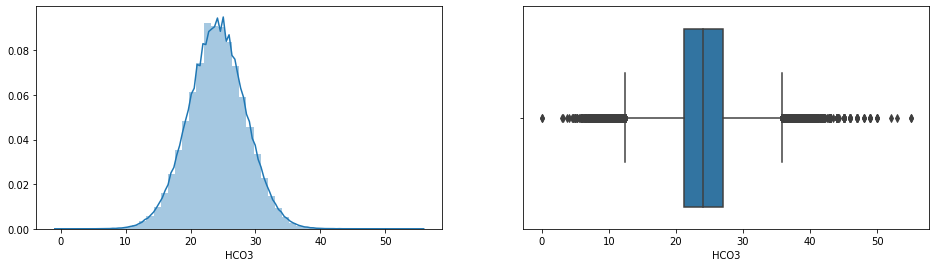

In [61]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['HCO3'])

plt.subplot(2,2,2)
sns.boxplot(df['HCO3'])

plt.show()

# FiO2 	Fraction of inspired oxygen (%)

In [62]:
df['FiO2'].describe()

count    112155.000000
mean          0.526248
std           0.185869
min           0.000000
25%           0.400000
50%           0.500000
75%           0.550000
max          10.000000
Name: FiO2, dtype: float64

In [63]:
df['FiO2'].isnull().sum()

678060

In [64]:
df['FiO2'].unique()

array([  nan,  0.28,  0.3 ,  0.25,  0.5 ,  0.8 ,  0.6 ,  0.4 ,  1.  ,
        0.95,  0.88,  0.78,  0.7 ,  0.65,  0.35,  0.55,  0.75,  0.45,
        0.04,  0.59,  0.03,  0.02,  0.98,  0.21,  0.73,  0.85,  0.43,
        0.9 ,  0.48,  0.41,  0.34,  0.57,  0.1 ,  0.  ,  0.2 ,  0.32,
        0.53,  0.68,  0.96,  0.05,  0.38,  0.27,  0.36,  0.39,  0.22,
        0.97,  0.94,  0.61,  0.46,  0.52,  0.31,  0.99,  0.74,  0.49,
        0.92,  0.69,  0.33,  0.63,  0.06,  0.37,  7.  ,  0.93,  0.83,
        0.08,  0.51,  0.64,  0.87,  0.54,  0.58,  0.24,  0.23,  0.56,
        0.26,  0.12,  0.79,  0.67,  0.66,  0.29,  0.91,  0.62,  0.86,
        0.44,  0.47,  0.11,  0.42,  0.81, 10.  ,  0.82,  0.84,  0.76,
        0.71,  0.18,  0.15])

In [65]:
X = df['FiO2']
Y = df['SepsisLabel']
impute2=imputation(X,Y)            # Calling of imputation function.

In [66]:
impute2

array([[0.777, 0.   ],
       [0.706, 0.   ],
       [0.638, 0.   ],
       ...,
       [0.208, 1.   ],
       [0.357, 1.   ],
       [0.612, 1.   ]])

In [67]:
# To change the array values with same dataframe define above.

impute_df2=pd.DataFrame(impute2,columns=['base_imp','SepsisLabel'])

df['FiO2'] = impute_df2['base_imp']

In [68]:
df['FiO2'].describe()

count    790215.000000
mean          0.526160
std           0.185881
min          -0.341000
25%           0.400000
50%           0.507000
75%           0.645000
max          10.000000
Name: FiO2, dtype: float64

In [69]:
df['FiO2'].unique()

array([ 0.777,  0.706,  0.638, ..., -0.17 , -0.242,  1.147])

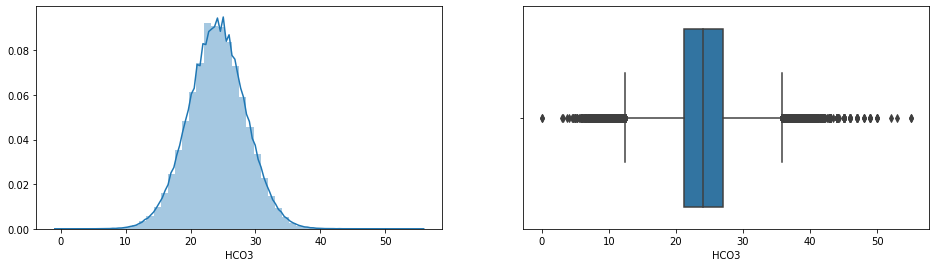

In [70]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['HCO3'])

plt.subplot(2,2,2)
sns.boxplot(df['HCO3'])

plt.show()

# pH 	N/A

In [71]:
df['pH'].describe()

count    90615.000000
mean         7.380243
std          0.071877
min          6.620000
25%          7.340000
50%          7.390000
75%          7.430000
max          7.930000
Name: pH, dtype: float64

In [72]:
df['pH'].unique()

array([ nan, 7.36, 7.4 , 7.37, 7.34, 7.33, 7.31, 7.32, 7.51, 7.49, 7.41,
       7.22, 7.38, 7.27, 7.35, 7.15, 7.13, 7.3 , 7.28, 7.29, 7.39, 7.44,
       7.45, 7.42, 7.43, 7.46, 7.47, 7.23, 7.24, 7.26, 7.25, 7.2 , 7.12,
       7.53, 7.48, 7.17, 7.5 , 6.98, 7.19, 7.21, 7.07, 6.87, 7.52, 7.58,
       7.14, 7.09, 7.18, 7.16, 7.08, 6.96, 7.  , 6.85, 7.54, 7.55, 7.56,
       7.1 , 7.11, 6.82, 6.95, 7.01, 7.05, 7.04, 7.03, 7.73, 7.59, 7.06,
       7.02, 6.86, 6.62, 6.8 , 6.79, 7.6 , 7.57, 7.62, 6.97, 6.9 , 7.61,
       6.65, 6.99, 7.65, 7.78, 7.68, 6.89, 7.64, 6.92, 6.88, 7.63, 6.94,
       7.66, 6.81, 7.67, 6.93, 7.69, 7.8 , 6.63, 7.71, 6.78, 6.91, 7.93,
       7.72])

In [73]:
df['pH'].isnull().sum()

699600

In [74]:
X = df['pH']
Y = df['SepsisLabel']
impute3=imputation(X,Y)            # Calling of imputation function.

In [75]:
impute3

array([[7.424, 0.   ],
       [7.335, 0.   ],
       [7.444, 0.   ],
       ...,
       [7.317, 1.   ],
       [7.422, 1.   ],
       [7.4  , 1.   ]])

In [76]:
# To change the array values with same dataframe define above.

impute_df3=pd.DataFrame(impute3,columns=['base_imp','SepsisLabel'])

df['pH'] = impute_df3['base_imp']

In [77]:
df['pH'].describe()

count    790215.000000
mean          7.380381
std           0.071886
min           6.620000
25%           7.333000
50%           7.380000
75%           7.429000
max           7.930000
Name: pH, dtype: float64

In [78]:
df['pH'].unique()

array([7.424, 7.335, 7.444, 7.36 , 7.312, 7.401, 7.461, 7.253, 7.386,
       7.35 , 7.4  , 7.349, 7.374, 7.445, 7.338, 7.22 , 7.37 , 7.392,
       7.39 , 7.448, 7.501, 7.148, 7.428, 7.34 , 7.28 , 7.314, 7.514,
       7.353, 7.397, 7.337, 7.336, 7.352, 7.281, 7.433, 7.422, 7.333,
       7.225, 7.261, 7.33 , 7.569, 7.506, 7.308, 7.305, 7.31 , 7.32 ,
       7.251, 7.449, 7.341, 7.325, 7.309, 7.284, 7.262, 7.345, 7.472,
       7.264, 7.439, 7.282, 7.38 , 7.369, 7.326, 7.46 , 7.317, 7.441,
       7.364, 7.381, 7.238, 7.288, 7.486, 7.233, 7.419, 7.332, 7.456,
       7.43 , 7.406, 7.432, 7.51 , 7.368, 7.429, 7.511, 7.271, 7.418,
       7.403, 7.493, 7.365, 7.518, 7.475, 7.411, 7.465, 7.49 , 7.343,
       7.334, 7.454, 7.442, 7.499, 7.357, 7.378, 7.415, 7.245, 7.384,
       7.344, 7.361, 7.222, 7.562, 7.299, 7.466, 7.523, 7.44 , 7.41 ,
       7.356, 7.526, 7.358, 7.426, 7.255, 7.388, 7.408, 7.423, 7.42 ,
       7.359, 7.412, 7.45 , 7.425, 7.372, 7.565, 7.467, 7.295, 7.362,
       7.351, 7.289,

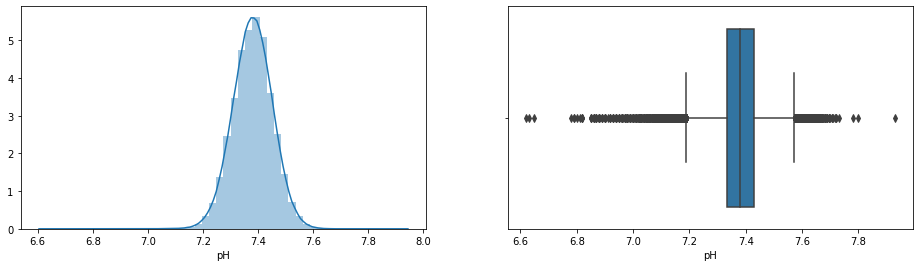

In [79]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['pH'])

plt.subplot(2,2,2)
sns.boxplot(df['pH'])

plt.show()

# PaCO2 	Partial pressure of carbon dioxide from arterial blood (mm Hg)

In [80]:
df['PaCO2'].describe()

count    69288.000000
mean        41.166147
std          8.996604
min         10.000000
25%         36.000000
50%         40.000000
75%         45.000000
max        100.000000
Name: PaCO2, dtype: float64

In [81]:
df['PaCO2'].unique()

array([  nan, 100. ,  86. ,  90. ,  96. ,  41. ,  38. ,  45. ,  47. ,
        36. ,  23. ,  25. ,  28. ,  27. ,  37. ,  30. ,  26. ,  22. ,
        32. ,  66. ,  80.5,  52. ,  42. ,  54. ,  46. ,  51. ,  49. ,
        48. ,  40. ,  35. ,  50. ,  55. ,  49.5,  43. ,  33. ,  41.5,
        31. ,  39. ,  34. ,  44. ,  65. ,  61. ,  62. ,  53. ,  59. ,
        63. ,  70. ,  58. ,  64. ,  57. ,  60. ,  89. ,  81. ,  56. ,
        74. ,  67. ,  75. ,  46.5,  29. ,  64.5,  54.5,  42.5,  18. ,
        21. ,  17. ,  68. ,  72. ,  80. ,  77. ,  78. ,  82. ,  44.5,
        39.5,  31.5,  32.5,  76. ,  79. ,  48.5,  43.5,  85. ,  73. ,
        69. ,  51.5,  92. ,  47.5,  35.5,  24. ,  25.5,  15. ,  29.5,
        45.5,  71. ,  50.5,  57.5,  52.5,  38.5,  36.5,  34.5,  67.5,
        16. ,  37.5,  27.5,  14. ,  33.5,  93. ,  84. ,  98. ,  91. ,
        87. ,  19. ,  99. ,  20. ,  78.5,  69.5,  60.5,  97. ,  53.5,
        10. ,  94. ,  63.5,  30.5,  83. ,  40.5,  77.5,  58.5,  56.5,
        71.5,  70.5,

In [82]:
df['PaCO2'].isnull().sum()

720927

In [83]:
X = df['PaCO2']
Y = df['SepsisLabel']
impute4=imputation(X,Y)            # Calling of imputation function.

In [84]:
impute4

array([[46.239,  0.   ],
       [41.916,  0.   ],
       [28.052,  0.   ],
       ...,
       [58.538,  1.   ],
       [66.193,  1.   ],
       [50.417,  1.   ]])

In [85]:
# To change the array values with same dataframe define above.

impute_df4=pd.DataFrame(impute4,columns=['base_imp','SepsisLabel'])

df['PaCO2'] = impute_df4['base_imp']

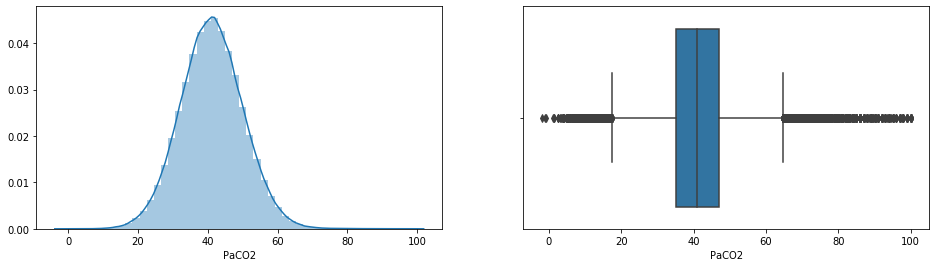

In [86]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['PaCO2'])

plt.subplot(2,2,2)
sns.boxplot(df['PaCO2'])

plt.show()

# SaO2 	Oxygen saturation from arterial blood (%)

In [87]:
df['SaO2'].describe()

count    39160.000000
mean        91.215456
std         12.226230
min         24.000000
25%         93.000000
50%         97.000000
75%         98.000000
max        100.000000
Name: SaO2, dtype: float64

In [88]:
df['SaO2'].unique()

array([   nan,  88.  ,  91.  ,  78.  ,  89.  ,  98.  ,  97.5 ,  99.  ,
        96.  ,  75.  ,  76.  ,  97.  ,  86.5 ,  74.  ,  66.5 ,  95.5 ,
        62.  ,  95.  ,  94.  ,  70.  ,  71.  ,  81.  ,  92.  ,  93.  ,
        67.  ,  77.  ,  78.5 ,  98.5 ,  60.  ,  79.  ,  75.5 ,  72.5 ,
        84.  ,  72.  ,  80.  ,  66.  ,  67.5 ,  73.  ,  90.  ,  53.  ,
        68.  ,  69.  ,  96.5 ,  84.5 ,  77.5 ,  85.  ,  89.5 ,  94.5 ,
        59.  ,  65.  , 100.  ,  56.  ,  63.  ,  61.  ,  93.5 ,  79.5 ,
        58.  ,  50.  ,  54.  ,  49.  ,  82.5 ,  83.5 ,  86.  ,  64.  ,
        92.5 ,  51.  ,  82.  ,  32.  ,  83.  ,  40.5 ,  76.5 ,  44.  ,
        88.5 ,  42.  ,  81.5 ,  85.5 ,  91.5 ,  87.  ,  57.  ,  52.  ,
        40.  ,  90.5 ,  47.  ,  55.  ,  80.5 ,  48.  ,  45.  ,  87.5 ,
        74.5 ,  46.  ,  43.  ,  55.5 ,  60.5 ,  62.5 ,  73.5 ,  70.5 ,
        63.5 ,  34.  ,  39.  ,  96.75,  69.5 ,  29.  ,  57.5 ,  35.  ,
        64.5 ,  89.75,  41.  ,  68.5 ,  31.  ,  54.5 ,  30.  ,  52.5 ,
      

In [89]:
X = df['SaO2']
Y = df['SepsisLabel']
impute5=imputation(X,Y)            # Calling of imputation function.

In [90]:
impute5

array([[82.225,  0.   ],
       [72.403,  0.   ],
       [87.468,  0.   ],
       ...,
       [93.474,  1.   ],
       [88.952,  1.   ],
       [98.   ,  1.   ]])

In [91]:
# To change the array values with same dataframe define above.

impute_df5=pd.DataFrame(impute5,columns=['base_imp','SepsisLabel'])

df['SaO2'] = impute_df5['base_imp']

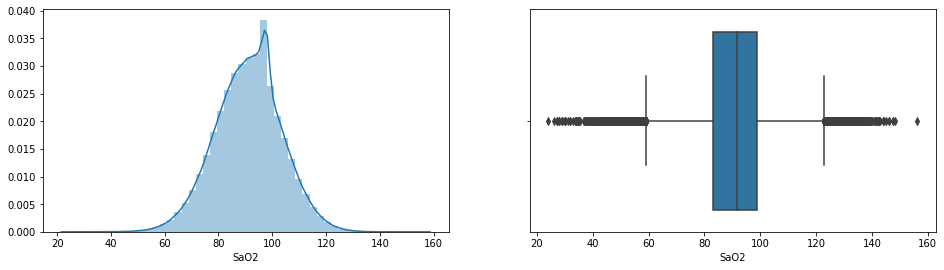

In [92]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['SaO2'])

plt.subplot(2,2,2)
sns.boxplot(df['SaO2'])

plt.show()

# AST 	Aspartate transaminase (IU/L)

In [93]:
df['AST'].describe()

count    11820.000000
mean       356.207530
std       1025.654672
min          3.000000
25%         28.000000
50%         57.000000
75%        180.000000
max       9890.000000
Name: AST, dtype: float64

In [94]:
df['AST'].unique()

array([  nan,   16.,   30., ..., 4828.,  698.,  342.])

In [95]:
X = df['AST']
Y = df['SepsisLabel']
impute6=imputation(X,Y)            # Calling of imputation function.

In [96]:
impute6

array([[ 2.139263e+03,  0.000000e+00],
       [ 2.533760e+02,  0.000000e+00],
       [-2.791240e+02,  0.000000e+00],
       ...,
       [ 8.308080e+02,  1.000000e+00],
       [-5.405900e+02,  1.000000e+00],
       [ 3.569850e+02,  1.000000e+00]])

In [97]:
# To change the array values with same dataframe define above.

impute_df6=pd.DataFrame(impute6,columns=['base_imp','SepsisLabel'])

df['AST'] = impute_df6['base_imp']

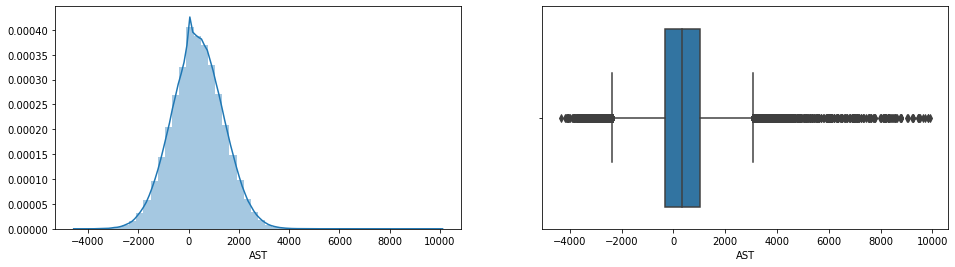

In [98]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['AST'])

plt.subplot(2,2,2)
sns.boxplot(df['AST'])

plt.show()

# BUN 	Blood urea nitrogen (mg/dL)

In [99]:
df['BUN'].describe()

count    64476.000000
mean        24.346709
std         20.154437
min          1.000000
25%         12.000000
50%         18.000000
75%         29.000000
max        266.000000
Name: BUN, dtype: float64

In [100]:
X = df['BUN']
Y = df['SepsisLabel']
impute7=imputation(X,Y)            # Calling of imputation function.

In [101]:
impute7

array([[-7.788,  0.   ],
       [11.668,  0.   ],
       [43.169,  0.   ],
       ...,
       [45.04 ,  1.   ],
       [46.965,  1.   ],
       [69.376,  1.   ]])

In [102]:
# To change the array values with same dataframe define above.

impute_df7=pd.DataFrame(impute7,columns=['base_imp','SepsisLabel'])

df['BUN'] = impute_df7['base_imp']

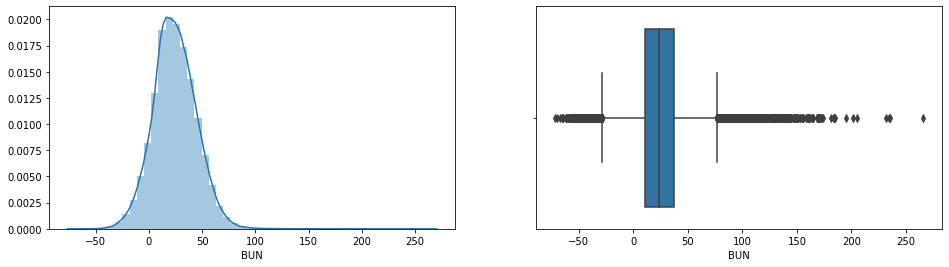

In [103]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['BUN'])

plt.subplot(2,2,2)
sns.boxplot(df['BUN'])

plt.show()

# Alkalinephos 	Alkaline phosphatase (IU/L)

In [104]:
df['Alkalinephos'].describe()

count    11532.000000
mean       114.203304
std        147.362802
min          7.000000
25%         56.000000
50%         78.000000
75%        119.000000
max       3833.000000
Name: Alkalinephos, dtype: float64

In [105]:
X = df['Alkalinephos']
Y = df['SepsisLabel']
impute8=imputation(X,Y)            # Calling of imputation function.

In [106]:
impute8

array([[ 98.107,   0.   ],
       [264.485,   0.   ],
       [194.154,   0.   ],
       ...,
       [ 76.429,   1.   ],
       [ 44.925,   1.   ],
       [241.357,   1.   ]])

In [107]:
# To change the array values with same dataframe define above.

impute_df8=pd.DataFrame(impute8,columns=['base_imp','SepsisLabel'])

df['Alkalinephos'] = impute_df8['base_imp']

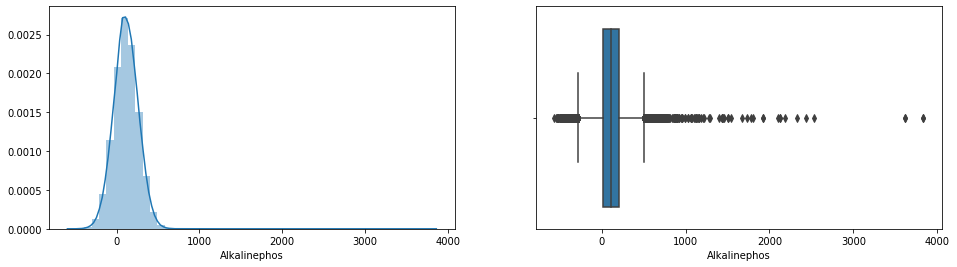

In [108]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Alkalinephos'])

plt.subplot(2,2,2)
sns.boxplot(df['Alkalinephos'])

plt.show()

# Calcium 	(mg/dL)

In [109]:
df['Calcium'].describe()

count    39318.000000
mean         8.316977
std          0.819304
min          1.600000
25%          7.800000
50%          8.300000
75%          8.800000
max         22.000000
Name: Calcium, dtype: float64

In [110]:
df['Calcium'].unique()

array([  nan,  9.3 ,  9.6 ,  7.9 , 11.1 , 10.9 , 11.  ,  8.2 ,  7.8 ,
        8.5 ,  5.9 ,  7.  ,  7.4 ,  7.3 ,  8.  ,  8.1 ,  7.7 ,  7.5 ,
        7.6 ,  8.3 ,  8.7 ,  8.4 ,  9.  ,  8.9 ,  9.9 ,  6.6 ,  7.2 ,
        7.1 ,  6.9 ,  8.6 ,  8.8 ,  9.8 ,  9.7 ,  9.2 ,  6.2 ,  9.1 ,
        9.4 ,  9.5 , 10.3 ,  6.8 ,  6.3 ,  6.1 , 13.3 , 14.9 , 14.1 ,
       12.7 , 11.7 , 10.8 , 10.  , 10.1 , 12.5 ,  6.7 , 10.7 , 12.4 ,
       12.9 , 11.2 , 10.6 ,  5.6 ,  4.7 , 10.2 ,  6.5 ,  6.  , 10.4 ,
        5.1 ,  6.4 ,  5.7 ,  5.8 ,  5.  , 15.4 , 13.  ,  5.5 , 11.9 ,
       11.8 , 11.6 , 10.35,  5.2 ,  5.3 ,  5.4 ,  7.65, 10.5 ,  8.25,
        4.8 ,  8.35, 11.5 , 11.3 , 12.8 ,  7.35, 12.1 , 13.4 ,  4.5 ,
       11.4 ,  3.5 , 15.2 , 14.3 , 13.6 , 12.2 , 18.4 , 22.  ,  8.15,
        3.6 , 12.3 , 14.6 ,  4.9 , 13.9 , 14.  ,  4.6 ,  3.9 ,  4.4 ,
        4.2 , 21.5 , 17.5 , 14.8 , 12.  ,  2.8 , 17.  , 19.6 ,  7.95,
        8.45, 13.1 , 15.6 , 14.7 , 13.5 ,  4.3 , 14.5 , 12.6 , 19.2 ,
       16.6 ,  3.7 ,

In [111]:
X = df['Calcium']
Y = df['SepsisLabel']
impute9=imputation(X,Y)            # Calling of imputation function.

In [112]:
impute9

array([[10.226,  0.   ],
       [ 7.003,  0.   ],
       [ 9.813,  0.   ],
       ...,
       [ 8.108,  1.   ],
       [ 7.091,  1.   ],
       [ 9.281,  1.   ]])

In [113]:
# To change the array values with same dataframe define above.

impute_df9=pd.DataFrame(impute9,columns=['base_imp','SepsisLabel'])

df['Calcium'] = impute_df9['base_imp']

In [114]:
df['Calcium'].describe()

count    790215.000000
mean          8.315234
std           0.820186
min           1.600000
25%           7.766000
50%           8.312000
75%           8.864000
max          22.000000
Name: Calcium, dtype: float64

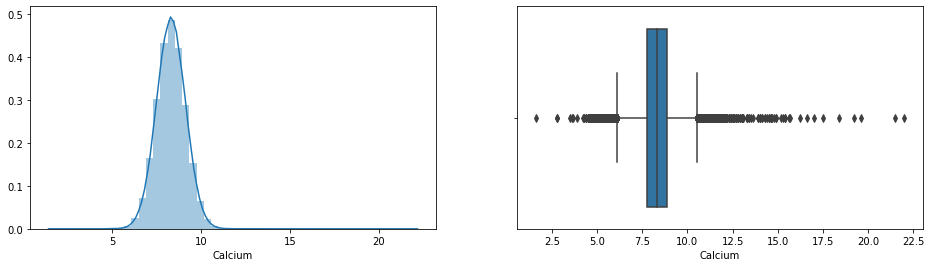

In [115]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Calcium'])

plt.subplot(2,2,2)
sns.boxplot(df['Calcium'])

plt.show()

# Chloride 	(mmol/L)

In [116]:
df['Chloride'].describe()

count    65777.000000
mean       105.765062
std          5.939929
min         26.000000
25%        102.000000
50%        106.000000
75%        109.000000
max        145.000000
Name: Chloride, dtype: float64

In [117]:
df['Chloride'].unique()

array([  nan,  85. , 113. ,  99. ,  98. , 100. , 105. , 108. , 106. ,
       111. , 116. , 115. , 122. , 123. , 107. , 110. , 103. , 104. ,
       112. , 109. , 102. , 101. ,  95. ,  96. , 114. ,  88. ,  92. ,
        94. ,  97. ,  93. , 117. , 118. , 120. ,  90. ,  91. , 105.5,
        83. ,  84. ,  87. , 119. ,  86. , 121. ,  89. , 125. , 126. ,
        79. ,  80. , 131. , 127. , 124. , 103.5, 132. , 129. , 109.5,
       130. ,  78. ,  81. ,  82. , 112.5, 135. , 107.5, 139. ,  96.5,
        75. , 110.5, 138. , 140. , 137. , 133. , 108.5, 134. , 128. ,
        99.5, 136. , 141. ,  93.5, 106.5,  94.5, 113.5,  97.5,  74. ,
       111.5, 122.5, 145. ,  76. ,  77. , 104.5, 126.5,  26. ,  38. ,
        73. , 102.5, 100.5,  67. ,  69. ,  66. ,  63. ,  70. , 118.5,
        91.5])

In [118]:
X = df['Chloride']
Y = df['SepsisLabel']
impute10=imputation(X,Y)            # Calling of imputation function.

In [119]:
# To change the array values with same dataframe define above.

impute_df10=pd.DataFrame(impute10,columns=['base_imp','SepsisLabel'])

df['Chloride'] = impute_df10['base_imp']

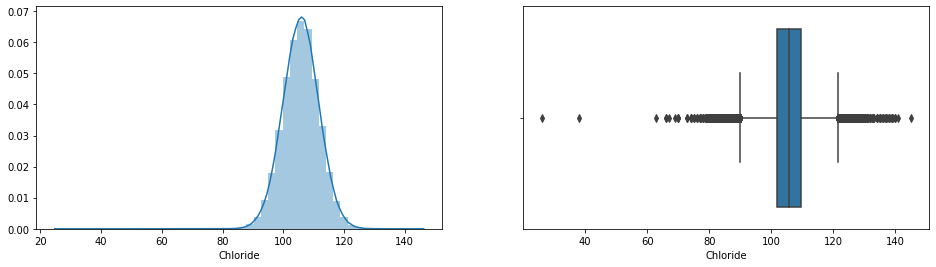

In [120]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Chloride'])

plt.subplot(2,2,2)
sns.boxplot(df['Chloride'])

plt.show()

# Creatinine 	(mg/dL)

In [121]:
df['Creatinine'].describe()

count    52487.000000
mean         1.404382
std          1.527545
min          0.100000
25%          0.700000
50%          0.900000
75%          1.400000
max         46.600000
Name: Creatinine, dtype: float64

In [122]:
df['Creatinine'].unique()

array([  nan,  0.7 ,  2.5 ,  0.9 ,  0.8 ,  0.6 ,  3.8 ,  3.9 ,  3.6 ,
        3.5 ,  1.2 ,  1.1 ,  1.3 ,  1.  ,  4.3 ,  4.4 ,  0.5 ,  0.4 ,
        0.3 ,  8.1 ,  7.8 ,  7.6 ,  7.9 ,  8.3 ,  8.7 ,  8.8 ,  7.  ,
        1.5 ,  8.6 ,  5.6 ,  2.2 ,  2.6 ,  2.  ,  2.1 ,  3.1 ,  2.8 ,
        2.7 ,  2.4 ,  2.3 ,  3.  ,  1.4 , 10.6 ,  1.6 ,  5.8 ,  1.7 ,
        0.2 ,  1.8 ,  1.9 ,  6.6 ,  4.  ,  3.4 ,  3.3 ,  3.2 ,  2.9 ,
        4.7 ,  5.1 ,  6.3 ,  6.5 ,  5.7 ,  6.2 ,  6.8 ,  7.1 ,  5.  ,
        4.6 ,  7.4 ,  3.7 ,  4.1 ,  6.  ,  6.9 ,  5.2 ,  4.5 ,  5.5 ,
       10.2 ,  4.9 ,  5.4 ,  6.4 ,  8.5 ,  4.2 ,  6.1 ,  5.9 ,  5.3 ,
       11.6 , 11.9 , 11.7 , 11.2 ,  4.8 , 10.  , 10.5 ,  7.3 ,  7.7 ,
        7.2 ,  6.7 ,  9.  ,  9.1 ,  8.9 ,  0.75, 16.  , 15.7 ,  7.5 ,
        8.  ,  9.5 , 10.3 , 11.3 ,  9.3 ,  1.05,  9.8 ,  9.9 ,  9.4 ,
        9.6 ,  9.7 ,  8.2 , 10.7 , 10.9 , 11.8 , 10.8 ,  1.45,  8.4 ,
       10.1 ,  9.2 ,  0.1 , 15.  , 15.5 , 16.1 , 16.2 , 17.  , 13.3 ,
        0.65, 12.2 ,

In [123]:
X = df['Creatinine']
Y = df['SepsisLabel']
impute11=imputation(X,Y)            # Calling of imputation function.

In [124]:
impute11

array([[ 3.041,  0.   ],
       [ 1.643,  0.   ],
       [ 4.079,  0.   ],
       ...,
       [ 3.657,  1.   ],
       [-0.599,  1.   ],
       [-1.279,  1.   ]])

In [125]:
# To change the array values with same dataframe define above.

impute_df11=pd.DataFrame(impute11,columns=['base_imp','SepsisLabel'])

df['Creatinine'] = impute_df11['base_imp']

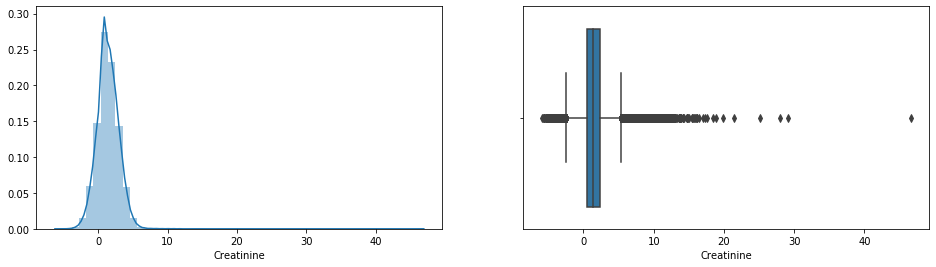

In [126]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Creatinine'])

plt.subplot(2,2,2)
sns.boxplot(df['Creatinine'])

plt.show()

# Bilirubin_direct 	Bilirubin direct (mg/dL)

In [127]:
df['Bilirubin_direct'].describe()

count    1182.000000
mean        3.114213
std         4.631447
min         0.100000
25%         0.500000
50%         1.400000
75%         3.700000
max        37.500000
Name: Bilirubin_direct, dtype: float64

In [128]:
df =df.drop(['Bilirubin_direct'],axis=1)

# Glucose 	Serum glucose (mg/dL)

In [129]:
df['Glucose'].describe()

count    96656.000000
mean       133.609221
std         51.583580
min         10.000000
25%        104.000000
50%        124.000000
75%        150.000000
max        988.000000
Name: Glucose, dtype: float64

In [130]:
X = df['Glucose']
Y = df['SepsisLabel']
impute12=imputation(X,Y)            # Calling of imputation function.

In [131]:
impute12

array([[ 66.982,   0.   ],
       [149.748,   0.   ],
       [ 76.594,   0.   ],
       ...,
       [258.633,   1.   ],
       [ 77.584,   1.   ],
       [151.086,   1.   ]])

In [132]:
# To change the array values with same dataframe define above.

impute_df12=pd.DataFrame(impute12,columns=['base_imp','SepsisLabel'])

df['Glucose'] = impute_df12['base_imp']

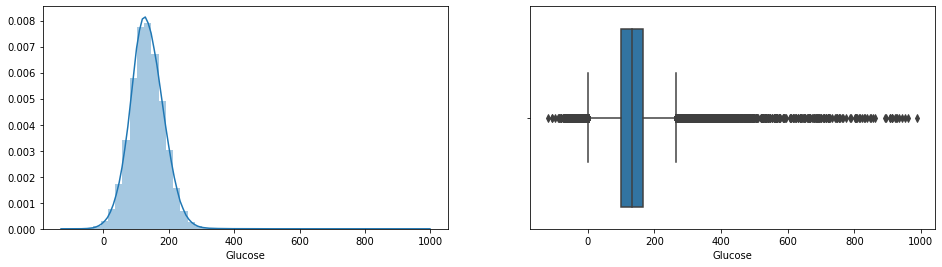

In [133]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Glucose'])

plt.subplot(2,2,2)
sns.boxplot(df['Glucose'])

plt.show()

# Lactate 	Lactic acid (mg/dL)

In [134]:
df['Lactate'].describe()

count    27143.000000
mean         2.469203
std          2.329001
min          0.200000
25%          1.200000
50%          1.800000
75%          2.800000
max         31.000000
Name: Lactate, dtype: float64

In [135]:
df =df.drop(['Lactate'],axis=1)

# Magnesium 	(mmol/dL)

In [136]:
df['Magnesium'].describe()

count    61481.000000
mean         2.041004
std          0.390028
min          0.200000
25%          1.800000
50%          2.000000
75%          2.200000
max          9.700000
Name: Magnesium, dtype: float64

In [137]:
X = df['Magnesium']
Y = df['SepsisLabel']
impute13=imputation(X,Y)            # Calling of imputation function.

In [138]:
impute13

array([[2.275, 0.   ],
       [1.927, 0.   ],
       [2.047, 0.   ],
       ...,
       [2.46 , 1.   ],
       [1.424, 1.   ],
       [1.648, 1.   ]])

In [139]:
# To change the array values with same dataframe define above.

impute_df13=pd.DataFrame(impute13,columns=['base_imp','SepsisLabel'])

df['Magnesium'] = impute_df13['base_imp']

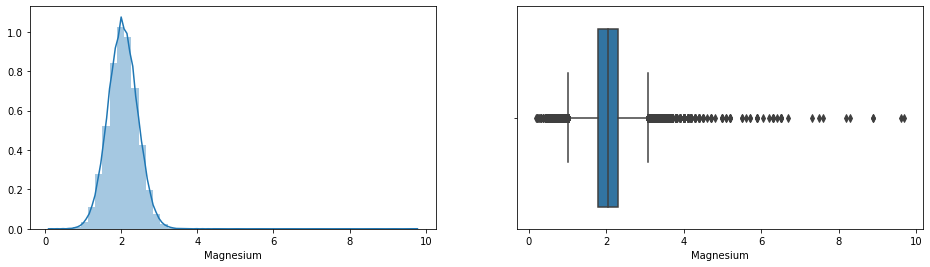

In [140]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Magnesium'])

plt.subplot(2,2,2)
sns.boxplot(df['Magnesium'])

plt.show()

# Phosphate 	(mg/dL)

In [141]:
df['Phosphate'].describe()

count    39896.000000
mean         3.588573
std          1.445632
min          0.200000
25%          2.700000
50%          3.400000
75%          4.200000
max         18.800000
Name: Phosphate, dtype: float64

In [142]:
df =df.drop(['Phosphate'],axis=1)

# Potassium 	(mmol/L)

In [143]:
df['Potassium'].describe()

count    85836.000000
mean         4.161507
std          0.632719
min          1.000000
25%          3.800000
50%          4.100000
75%          4.500000
max         27.500000
Name: Potassium, dtype: float64

In [144]:
X = df['Potassium']
Y = df['SepsisLabel']
impute14=imputation(X,Y)            # Calling of imputation function.

In [145]:
impute14

array([[3.85 , 0.   ],
       [5.013, 0.   ],
       [3.549, 0.   ],
       ...,
       [3.803, 1.   ],
       [4.037, 1.   ],
       [4.239, 1.   ]])

In [146]:
# To change the array values with same dataframe define above.

impute_df14=pd.DataFrame(impute14,columns=['base_imp','SepsisLabel'])

df['Potassium'] = impute_df14['base_imp']

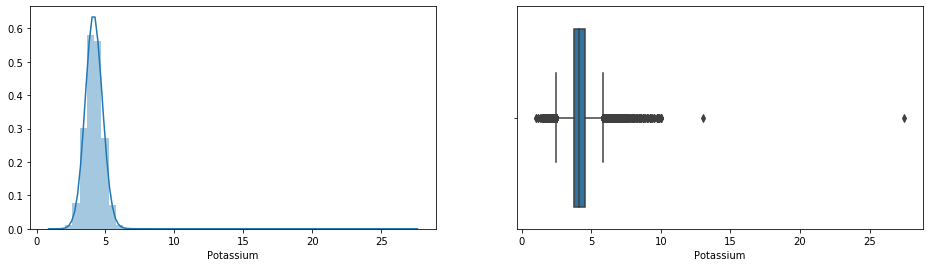

In [147]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Potassium'])

plt.subplot(2,2,2)
sns.boxplot(df['Potassium'])

plt.show()

# Bilirubin_total 	Total bilirubin (mg/dL)

In [148]:
df['Bilirubin_total'].describe()

count    9693.000000
mean        2.694403
std         5.242802
min         0.100000
25%         0.500000
50%         0.900000
75%         2.200000
max        46.600000
Name: Bilirubin_total, dtype: float64

In [149]:
df =df.drop(['Bilirubin_total'],axis=1)

# TroponinI 	Troponin I (ng/mL)

In [150]:
df['TroponinI'].describe()

count    965.000000
mean       9.288187
std       11.412870
min        0.300000
25%        1.000000
50%        4.300000
75%       12.900000
max       49.300000
Name: TroponinI, dtype: float64

In [151]:
df =df.drop(['TroponinI'],axis=1)

# Hct 	Hematocrit (%)

In [152]:
df['Hct'].describe()

count    93058.000000
mean        30.674895
std          4.874651
min          5.500000
25%         27.400000
50%         30.200000
75%         33.500000
max         71.700000
Name: Hct, dtype: float64

In [153]:
X = df['Hct']
Y = df['SepsisLabel']
impute15=imputation(X,Y)            # Calling of imputation function.

In [154]:
impute15

array([[27.504,  0.   ],
       [39.931,  0.   ],
       [20.512,  0.   ],
       ...,
       [31.229,  1.   ],
       [30.104,  1.   ],
       [25.032,  1.   ]])

In [155]:
# To change the array values with same dataframe define above.

impute_df15=pd.DataFrame(impute15,columns=['base_imp','SepsisLabel'])

df['Hct'] = impute_df15['base_imp']

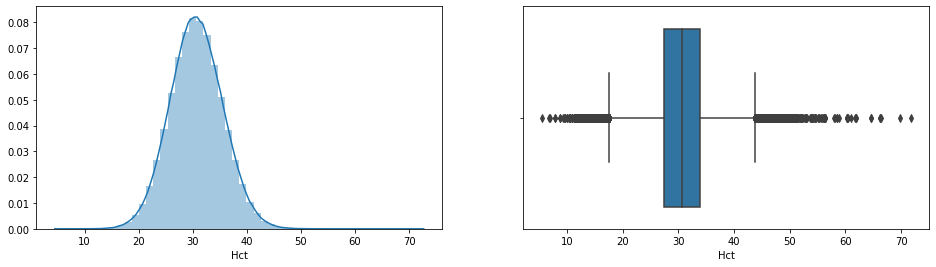

In [156]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Hct'])

plt.subplot(2,2,2)
sns.boxplot(df['Hct'])

plt.show()

# Hgb 	Hemoglobin (g/dL)

In [157]:
df['Hgb'].describe()

count    69821.000000
mean        10.582028
std          1.746027
min          2.200000
25%          9.400000
50%         10.400000
75%         11.600000
max         32.000000
Name: Hgb, dtype: float64

In [158]:
X = df['Hgb']
Y = df['SepsisLabel']
impute16=imputation(X,Y)            # Calling of imputation function.

In [159]:
impute16

array([[ 9.378,  0.   ],
       [ 9.6  ,  0.   ],
       [10.665,  0.   ],
       ...,
       [ 8.536,  1.   ],
       [ 9.969,  1.   ],
       [ 9.361,  1.   ]])

In [160]:
# To change the array values with same dataframe define above.

impute_df16=pd.DataFrame(impute16,columns=['base_imp','SepsisLabel'])

df['Hgb'] = impute_df16['base_imp']

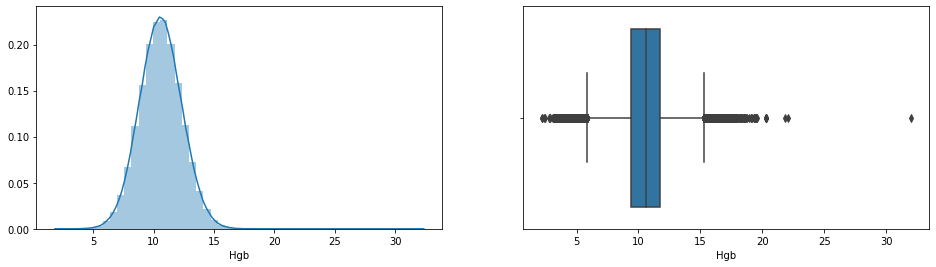

In [161]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Hgb'])

plt.subplot(2,2,2)
sns.boxplot(df['Hgb'])

plt.show()

# PTT 	partial thromboplastin time (seconds)

In [162]:
df['PTT'].describe()

count    38306.000000
mean        40.781937
std         23.964333
min         12.500000
25%         27.700000
50%         32.400000
75%         42.900000
max        150.000000
Name: PTT, dtype: float64

In [163]:
X = df['PTT']
Y = df['SepsisLabel']
impute17=imputation(X,Y)            # Calling of imputation function.

In [164]:
impute17

array([[76.108,  0.   ],
       [ 7.981,  0.   ],
       [59.676,  0.   ],
       ...,
       [46.145,  1.   ],
       [22.198,  1.   ],
       [64.828,  1.   ]])

In [165]:
# To change the array values with same dataframe define above.

impute_df17=pd.DataFrame(impute17,columns=['base_imp','SepsisLabel'])

df['PTT'] = impute_df17['base_imp']

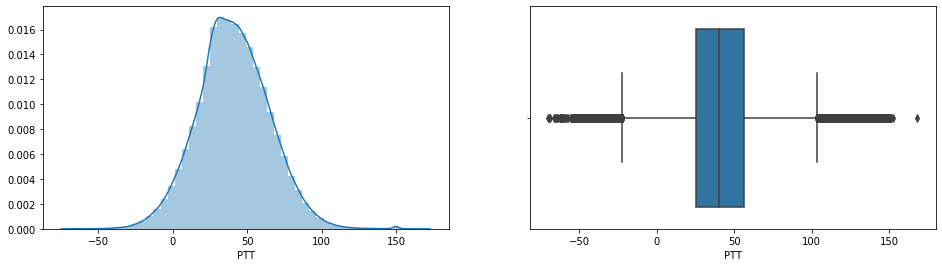

In [166]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['PTT'])

plt.subplot(2,2,2)
sns.boxplot(df['PTT'])

plt.show()

# WBC 	Leukocyte count (count*10^3/µL)

In [167]:
df['WBC'].describe()

count    59348.000000
mean        11.936604
std          7.562679
min          0.100000
25%          8.000000
50%         10.800000
75%         14.300000
max        422.900000
Name: WBC, dtype: float64

In [168]:
X = df['WBC']
Y = df['SepsisLabel']
impute18=imputation(X,Y)            # Calling of imputation function.

In [169]:
impute18

array([[ 5.581,  0.   ],
       [ 0.991,  0.   ],
       [11.8  ,  0.   ],
       ...,
       [16.18 ,  1.   ],
       [14.575,  1.   ],
       [13.622,  1.   ]])

In [170]:
# To change the array values with same dataframe define above.

impute_df18=pd.DataFrame(impute18,columns=['base_imp','SepsisLabel'])

df['WBC'] = impute_df18['base_imp']

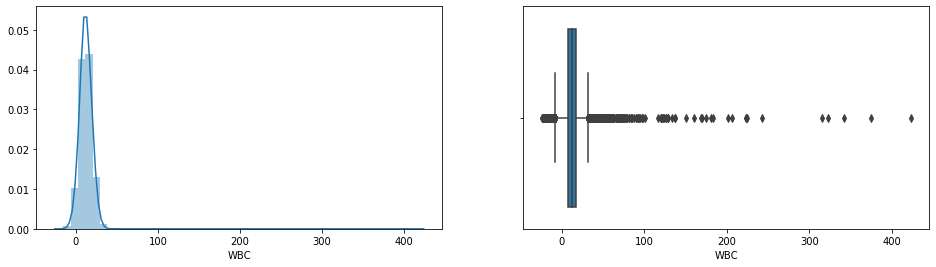

In [171]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['WBC'])

plt.subplot(2,2,2)
sns.boxplot(df['WBC'])

plt.show()

# Fibrinogen 	(mg/dL)

In [172]:
df['Fibrinogen'].describe()

count    6030.000000
mean      292.251642
std       158.632042
min        34.000000
25%       184.000000
50%       250.000000
75%       356.750000
max      1760.000000
Name: Fibrinogen, dtype: float64

In [173]:
df =df.drop(['Fibrinogen'],axis=1)

# Platelets 	(count*10^3/µL)

In [174]:
df['Platelets'].describe()

count    51499.000000
mean       199.617841
std        109.244146
min          5.000000
25%        127.000000
50%        181.000000
75%        247.000000
max       1783.000000
Name: Platelets, dtype: float64

In [175]:
X = df['Platelets']
Y = df['SepsisLabel']
impute19=imputation(X,Y)            # Calling of imputation function.

In [176]:
impute19

array([[ 65.144,   0.   ],
       [245.993,   0.   ],
       [253.276,   0.   ],
       ...,
       [342.159,   1.   ],
       [169.042,   1.   ],
       [202.946,   1.   ]])

In [177]:
# To change the array values with same dataframe define above.

impute_df19=pd.DataFrame(impute19,columns=['base_imp','SepsisLabel'])

df['Platelets'] = impute_df19['base_imp']

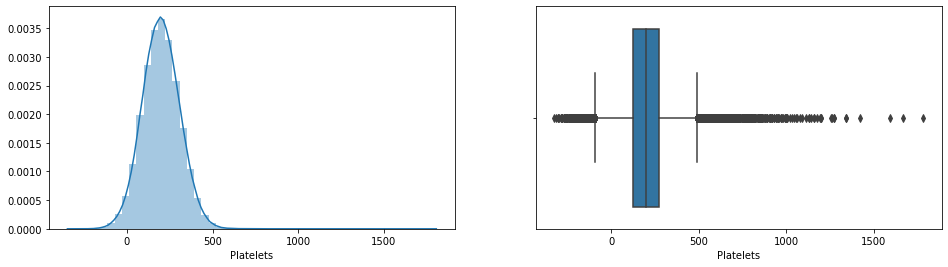

In [178]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Platelets'])

plt.subplot(2,2,2)
sns.boxplot(df['Platelets'])

plt.show()

In [180]:
df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,84.0,98.0,38.512,118.5,77.00,58.5,18.0,3.367,22.893,0.777,...,65.144,83.14,0,NaN,NaN,-0.03,1,0,0,0
1,97.0,95.0,36.964,98.0,75.33,58.5,19.0,5.614,19.332,0.706,...,245.993,83.14,0,NaN,NaN,-0.03,2,0,0,1
2,89.0,99.0,36.043,122.0,86.00,58.5,22.0,3.578,26.322,0.638,...,253.276,83.14,0,NaN,NaN,-0.03,3,0,0,2
3,90.0,95.0,37.146,118.5,77.00,58.5,30.0,24.000,27.734,0.611,...,145.436,83.14,0,NaN,NaN,-0.03,4,0,0,3
4,103.0,88.5,37.512,122.0,91.33,58.5,24.5,2.259,21.844,0.280,...,-1.279,83.14,0,NaN,NaN,-0.03,5,0,0,4


# Demographics (columns 35-40)

# Age 	Years (100 for patients 90 or above)

In [181]:
df['Age'].describe()

count    790215.000000
mean         63.016780
std          16.133632
min          18.110000
25%          52.740000
50%          65.250000
75%          75.890000
max          89.000000
Name: Age, dtype: float64

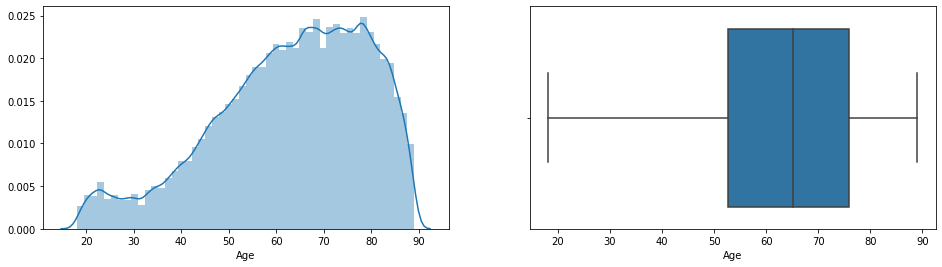

In [182]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Age'])

plt.subplot(2,2,2)
sns.boxplot(df['Age'])

plt.show()

# Gender 	Female (0) or Male (1)

In [183]:
df['Gender'].describe()

count    790215.000000
mean          0.577721
std           0.493923
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Gender, dtype: float64

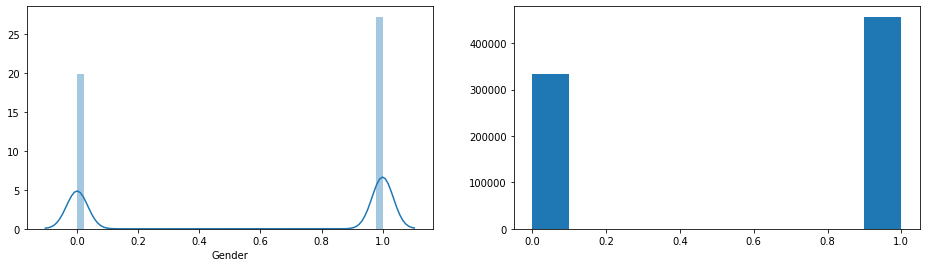

In [184]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Gender'])

plt.subplot(2,2,2)
plt.hist(df['Gender'])

plt.show()

# Unit1 	Administrative identifier for ICU unit (MICU)

In [185]:
df['Unit1'].describe()

count    404050.000000
mean          0.507101
std           0.499950
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Unit1, dtype: float64

In [186]:
df['Unit1']=df['Unit1'].fillna(1)

In [187]:
df['Unit1'].value_counts()

1.0    591059
0.0    199156
Name: Unit1, dtype: int64

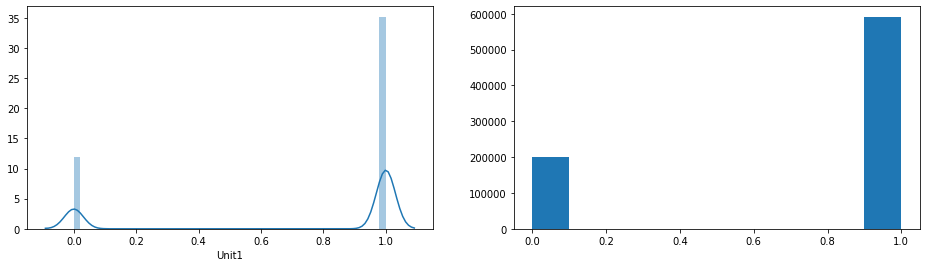

In [188]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Unit1'])

plt.subplot(2,2,2)
plt.hist(df['Unit1'])

plt.show()

# Unit2 	Administrative identifier for ICU unit (SICU)

In [189]:
df['Unit2'].describe()

count    404050.000000
mean          0.492899
std           0.499950
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Unit2, dtype: float64

In [190]:
df['Unit2'].value_counts()

0.0    204894
1.0    199156
Name: Unit2, dtype: int64

In [191]:
X = df['Platelets']
Y = df['SepsisLabel']
impute21=imputation(X,Y)            # Calling of imputation function.

In [192]:
impute21

array([[ 65.144,   0.   ],
       [245.993,   0.   ],
       [253.276,   0.   ],
       ...,
       [342.159,   1.   ],
       [169.042,   1.   ],
       [202.946,   1.   ]])

In [193]:
# To change the array values with same dataframe define above.

impute_df21=pd.DataFrame(impute21,columns=['base_imp','SepsisLabel'])

df['Unit2'] = impute_df21['base_imp']

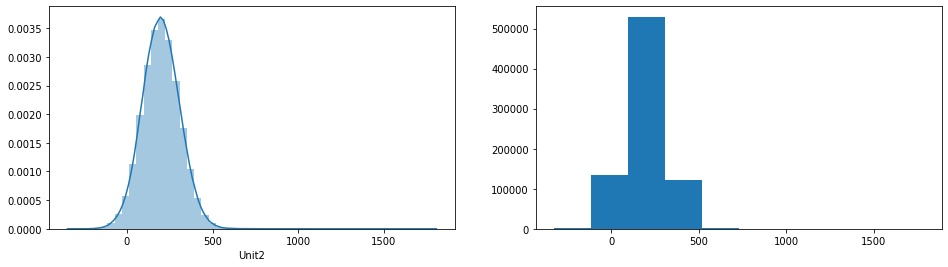

In [194]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['Unit2'])

plt.subplot(2,2,2)
plt.hist(df['Unit2'])

plt.show()


# HospAdmTime 	Hours between hospital admit and ICU admit

In [195]:
df['HospAdmTime'].describe()

count    790207.000000
mean        -52.025757
std         155.864937
min       -3710.660000
25%         -38.090000
50%          -2.600000
75%          -0.020000
max          23.990000
Name: HospAdmTime, dtype: float64

In [196]:
df['HospAdmTime'].mean()

-52.02575711174415

In [197]:
df['HospAdmTime']=df['HospAdmTime'].fillna(df['HospAdmTime'].mean())

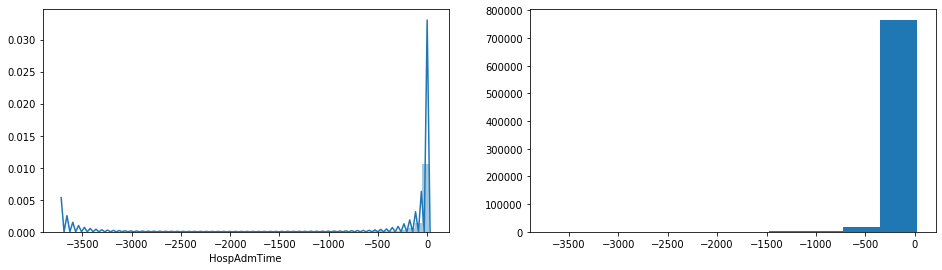

In [198]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['HospAdmTime'])

plt.subplot(2,2,2)
plt.hist(df['HospAdmTime'])

plt.show()

# ICULOS 	ICU length-of-stay (hours since ICU admit)

In [199]:
df['ICULOS'].describe()

count    790215.000000
mean         27.198518
std          28.190940
min           1.000000
25%          11.000000
50%          21.000000
75%          35.000000
max         336.000000
Name: ICULOS, dtype: float64

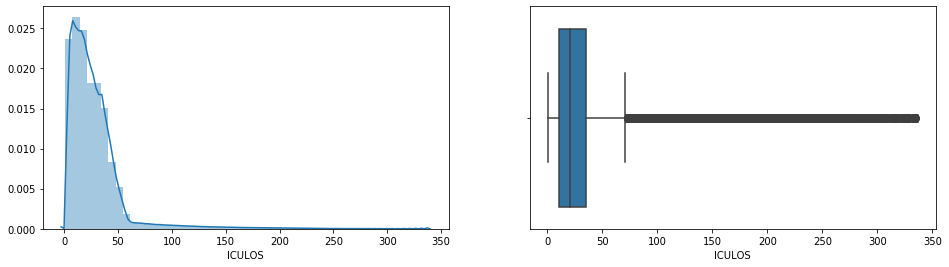

In [200]:
plt.figure(figsize=(16,9))

plt.subplot(2,2,1)
sns.distplot(df['ICULOS'])

plt.subplot(2,2,2)
sns.boxplot(df['ICULOS'])

plt.show()

In [201]:
pd.DataFrame().to_csv('sepsisclean.csv')

In [202]:
df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,84.0,98.0,38.512,118.5,77.00,58.5,18.0,3.367,22.893,0.777,...,65.144,83.14,0,1.0,65.144,-0.03,1,0,0,0
1,97.0,95.0,36.964,98.0,75.33,58.5,19.0,5.614,19.332,0.706,...,245.993,83.14,0,1.0,245.993,-0.03,2,0,0,1
2,89.0,99.0,36.043,122.0,86.00,58.5,22.0,3.578,26.322,0.638,...,253.276,83.14,0,1.0,253.276,-0.03,3,0,0,2
3,90.0,95.0,37.146,118.5,77.00,58.5,30.0,24.000,27.734,0.611,...,145.436,83.14,0,1.0,145.436,-0.03,4,0,0,3
4,103.0,88.5,37.512,122.0,91.33,58.5,24.5,2.259,21.844,0.280,...,-1.279,83.14,0,1.0,-1.279,-0.03,5,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,88.0,98.0,38.001,135.0,81.00,64.0,16.0,-3.367,24.371,0.500,...,334.589,62.29,1,1.0,334.589,-0.03,31,1,20335,28
790211,96.0,98.0,38.720,174.0,97.00,72.0,16.0,2.000,19.302,0.829,...,298.018,62.29,1,1.0,298.018,-0.03,32,1,20335,29
790212,140.0,97.0,37.271,133.0,81.50,62.5,16.0,-2.750,16.162,0.208,...,342.159,62.29,1,1.0,342.159,-0.03,33,1,20335,30
790213,120.0,96.0,38.147,154.0,118.00,105.0,16.0,-0.605,23.711,0.357,...,169.042,62.29,1,1.0,169.042,-0.03,34,1,20335,31


In [206]:
df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium',
       'Potassium', 'Hct', 'Hgb', 'PTT', 'WBC', 'Platelets', 'Age', 'Gender',
       'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_id',
       'time'],
      dtype='object')

In [210]:
pd.DataFrame(df).to_csv('sepsisclean.csv')

# implementation of model

In [216]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [214]:
X = df[['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'BaseExcess',
       'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
       'Calcium', 'Chloride', 'Creatinine', 'Glucose', 'Magnesium',
       'Potassium', 'Hct', 'Hgb', 'PTT', 'WBC', 'Platelets', 'Age', 'Gender',
       'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']]

y = df['SepsisLabel']

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30)

## randomforest

In [221]:
model = RandomForestClassifier(n_estimators=100,random_state=None,max_features = 'sqrt',n_jobs=-1, verbose = 1)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.9s finished


In [222]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))


[[231939      0]
 [  5125      1]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    231939
           1       1.00      0.00      0.00      5126

    accuracy                           0.98    237065
   macro avg       0.99      0.50      0.49    237065
weighted avg       0.98      0.98      0.97    237065

0.9783814565625462


## Create pickle file


In [224]:
import pickle
pickle.dump(model,open("sepsis_pred.pkl","wb"))

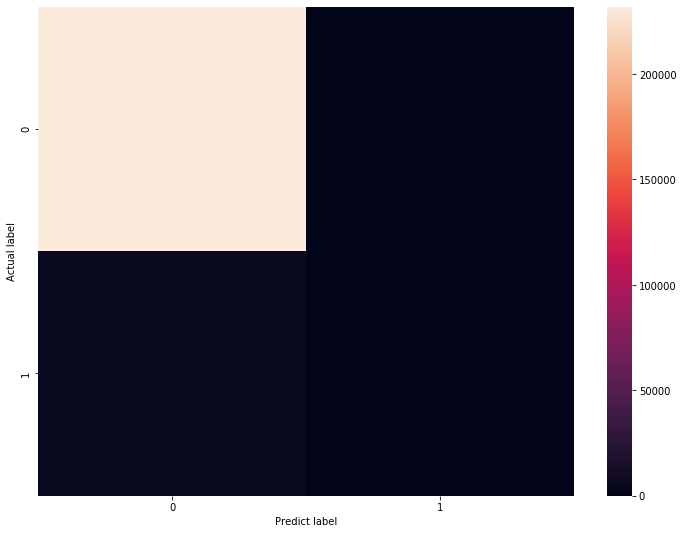

In [225]:
# create heapmap using seaborn
cm=confusion_matrix(y_test,y_pred)

plt.figure(figsize=(12,9))

sns.heatmap(cm)
plt.ylabel('Actual label');
plt.xlabel('Predict label');
plt.show()

In [227]:
df

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,84.0,98.0,38.512,118.5,77.00,58.5,18.0,3.367,22.893,0.777,...,65.144,83.14,0,1.0,65.144,-0.03,1,0,0,0
1,97.0,95.0,36.964,98.0,75.33,58.5,19.0,5.614,19.332,0.706,...,245.993,83.14,0,1.0,245.993,-0.03,2,0,0,1
2,89.0,99.0,36.043,122.0,86.00,58.5,22.0,3.578,26.322,0.638,...,253.276,83.14,0,1.0,253.276,-0.03,3,0,0,2
3,90.0,95.0,37.146,118.5,77.00,58.5,30.0,24.000,27.734,0.611,...,145.436,83.14,0,1.0,145.436,-0.03,4,0,0,3
4,103.0,88.5,37.512,122.0,91.33,58.5,24.5,2.259,21.844,0.280,...,-1.279,83.14,0,1.0,-1.279,-0.03,5,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,88.0,98.0,38.001,135.0,81.00,64.0,16.0,-3.367,24.371,0.500,...,334.589,62.29,1,1.0,334.589,-0.03,31,1,20335,28
790211,96.0,98.0,38.720,174.0,97.00,72.0,16.0,2.000,19.302,0.829,...,298.018,62.29,1,1.0,298.018,-0.03,32,1,20335,29
790212,140.0,97.0,37.271,133.0,81.50,62.5,16.0,-2.750,16.162,0.208,...,342.159,62.29,1,1.0,342.159,-0.03,33,1,20335,30
790213,120.0,96.0,38.147,154.0,118.00,105.0,16.0,-0.605,23.711,0.357,...,169.042,62.29,1,1.0,169.042,-0.03,34,1,20335,31


In [230]:
305+100+75+32+50+45+140+55+20+34+110+220+400+30+90+40+100+400+100+60+200+50+170+30+65+150+35+38+182+10+30+45+60+2000+200+20+1350+500+200

7741